# internal tide, delayed experiments

In [1]:
import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
%matplotlib inline

import crocosi.postp as pp

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*2)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.1.103:35722 Dashboard: http://10.148.1.103:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---
## setup diagnostics

In [3]:
# apply ufunc

def filter_omega(v, dt, Twin, Twin_one):

    t = np.arange(0,Twin,dt)

    def filter_one_location(v):
        # need to substract running mean value first, otherwise mean sign on cos projection
        # downside: this doubles side effects
        win_one = t[np.where(t<Twin_one)]*0.+1
        win_one = win_one/np.sum(win_one**2)
        v_low = np.convolve(win_one, v, mode='same')

        omega = 2.*2.*np.pi # rad/day
        win = np.cos(omega*t)
        win = win/np.sum(win**2)
        v_omega = np.convolve(win, v-v_low, mode='valid')
        return v_omega
    
    # loop over all dimensions but the last one to apply correlate
    Ni = v.shape[:-1]
    # infer number of lags from dummy computation
    vv = np.full(Ni+tuple([v.shape[-1]]), np.NaN)
    for ii in np.ndindex(Ni):
        f = filter_one_location(v[ii + np.s_[:,]])
        Nj = f.shape
        for jj in np.ndindex(Nj):
            vv[ii + jj] = f[jj]
            
    return vv


def wrap_filter(v, Twin=2, Twin_one=1):
    v = v.chunk({'time': -1})
    dt = (v.time[1]-v.time[0]).values
    out = xr.apply_ufunc(filter_omega, v, dt, Twin, Twin_one,
                         dask='parallelized',
                         input_core_dims=[['time'],[],[],[]],
                         output_core_dims=[['time']],
                         output_dtypes=[np.float64])
    return out

In [3]:
#root_path = '/home/c11-data/Test_aponte/jetn/'
#root_path = '/home1/scratch/aponte/'
root_path = '/home/datawork-lops-osi/equinox/jetn/'
r = pp.Run(root_path+'jet_wp5_dstart_m2_0', open_nc=['surf'])
r['surf'] = r['surf'].rename({'time_instant': 'time'})

In [4]:
ssh = r['surf'].ssh.chunk({'x_rho': 10, 'y_rho': 10, 'time': -1})

In [5]:
ssh.nbytes/1e9

10.7294976

In [6]:
v = ssh.isel(x_rho=0,y_rho=300).persist()

In [7]:
v

<xarray.DataArray 'ssh' (time: 14400)>
dask.array<getitem, shape=(14400,), dtype=float32, chunksize=(14400,), chunktype=numpy.ndarray>
Coordinates:
    x_rho         float32 -2000.0
    x_v           float32 dask.array<chunksize=(), meta=np.ndarray>
    y_u           float32 dask.array<chunksize=(), meta=np.ndarray>
    y_rho         float32 1198000.0
    s_rho_slice0  float32 -0.01
  * time          (time) float64 dask.array<chunksize=(14400,), meta=np.ndarray>
    time_counter  (time) float64 2e+03 2e+03 2e+03 ... 2.1e+03 2.1e+03 2.1e+03
    f_u           float32 dask.array<chunksize=(), meta=np.ndarray>
    f_rho         float32 dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    long_name:           free-surface
    units:               meter
    online_operation:    instant
    interval_operation:  600 s
    interval_write:      600 s
    cell_methods:        time: point

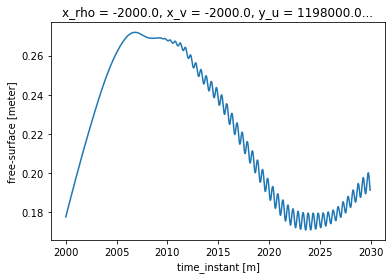

In [8]:
v.isel(time=slice(0,30*24*6,6)).plot()

In [10]:
dt = (v.time[1]-v.time[0]).values
Twin = 2.
t = np.arange(0,Twin,dt)

# need to substract running mean value first, otherwise mean sign on cos projection
# downside: this doubles side effects
win_one = t[np.where(t<1)]*0.+1
win_one = win_one/np.sum(win_one**2)
#v_one = np.convolve(win_one, v.values, mode='valid')
v_one = np.convolve(win_one, v.values, mode='same')

omega = 2.*2.*np.pi # rad/day
win = np.cos(omega*t)
win = win/np.sum(win**2)
v_conv = np.convolve(win, v.values-v_one, mode='valid')

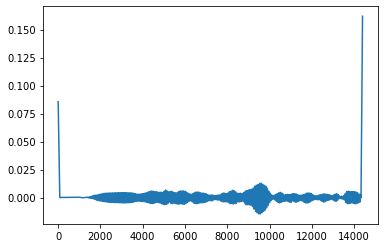

In [11]:
plt.plot(v.values-v_one)

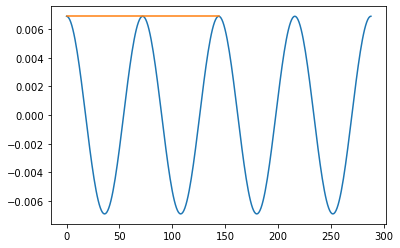

In [12]:
plt.plot(win)
plt.plot(win_one)

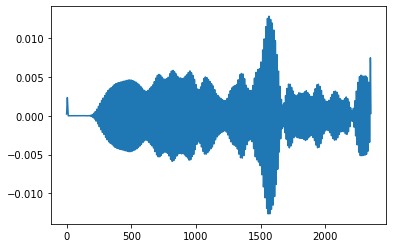

In [13]:
plt.plot(v_conv[::6])
#plt.plot(v_one[::6])

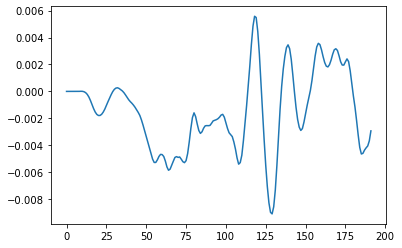

In [14]:
plt.plot(v_conv[2*24*6::6*12])

In [32]:
v_omega = wrap_filter(v)

In [33]:
v_omega

<xarray.DataArray 'ssh' (time: 14400)>
dask.array<filter_omega, shape=(14400,), dtype=float64, chunksize=(14400,), chunktype=numpy.ndarray>
Coordinates:
    x_rho         float32 -2000.0
    x_v           float32 dask.array<chunksize=(), meta=np.ndarray>
    y_u           float32 dask.array<chunksize=(), meta=np.ndarray>
    y_rho         float32 1198000.0
    s_rho_slice0  float32 -0.01
  * time          (time) float64 dask.array<chunksize=(14400,), meta=np.ndarray>
    time_counter  (time) float64 2e+03 2e+03 2e+03 ... 2.1e+03 2.1e+03 2.1e+03
    f_u           float32 dask.array<chunksize=(), meta=np.ndarray>
    f_rho         float32 dask.array<chunksize=(), meta=np.ndarray>

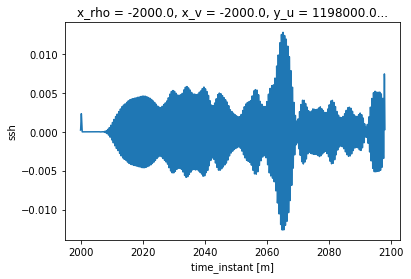

In [34]:
v_omega.isel(time=slice(0,None,6)).plot()

In [35]:
# apply on a meridional section
v = ssh.isel(x_rho=0).persist()

In [36]:
v

<xarray.DataArray 'ssh' (time: 14400, y_rho: 722)>
dask.array<getitem, shape=(14400, 722), dtype=float32, chunksize=(14400, 10), chunktype=numpy.ndarray>
Coordinates:
    x_rho         float32 -2000.0
    x_v           float32 dask.array<chunksize=(), meta=np.ndarray>
    y_u           (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
  * y_rho         (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
    s_rho_slice0  float32 -0.01
  * time          (time) float64 dask.array<chunksize=(14400,), meta=np.ndarray>
    time_counter  (time) float64 2e+03 2e+03 2e+03 ... 2.1e+03 2.1e+03 2.1e+03
    f_u           (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    f_rho         (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
Attributes:
    long_name:           free-surface
    units:               meter
    online_operation:    instant
    interval_operation:  600 s
    interval_write:      600 s
    cell_methods:        time: point

In [37]:
v_omega = wrap_filter(v)

In [38]:
v_omega

<xarray.DataArray 'ssh' (y_rho: 722, time: 14400)>
dask.array<filter_omega, shape=(722, 14400), dtype=float64, chunksize=(10, 14400), chunktype=numpy.ndarray>
Coordinates:
    x_rho         float32 -2000.0
    x_v           float32 dask.array<chunksize=(), meta=np.ndarray>
    y_u           (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
  * y_rho         (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
    s_rho_slice0  float32 -0.01
  * time          (time) float64 dask.array<chunksize=(14400,), meta=np.ndarray>
    time_counter  (time) float64 2e+03 2e+03 2e+03 ... 2.1e+03 2.1e+03 2.1e+03
    f_u           (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    f_rho         (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>

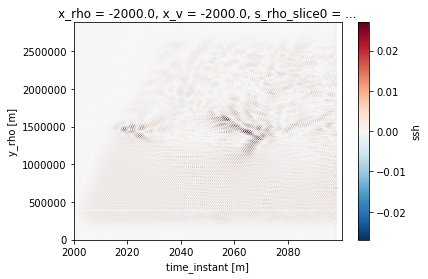

In [39]:
v_omega.isel(time=slice(0,None,6)).plot()

---
## process all runs

In [6]:
#root_path = '/home/c11-data/Test_aponte/jetn/'
#root_path = '/home1/scratch/aponte/'
root_path = '/home/datawork-lops-osi/equinox/jetn/'

nmode = 1
ix=0

runs = ([root_path+'jet_wp5_ptb_m1_p4'] + 
        [root_path+'jet_wp5_dstart_m%d_%d'%(nmode, i) for i in range(4)]
       )

# these should be derived from params_output but online param float output should be improved
start_shifts = [0, 0.5, 1, 2, 4]

R = []
V = []
for r in runs:
    _r = pp.Run(r, open_nc=['surf'])
    _r['surf'] = _r['surf'].rename({'time_instant': 'time'})
    R.append(_r)
    V.append(_r['surf'].ssh
              .isel(x_rho=ix)
              .chunk({'y_rho': 10, 'time': -1})
              .persist())

Exception ignored in: <function Run.__del__ at 0x2aab06331598>
Traceback (most recent call last):
  File "/home1/datahome/aponte/croco/crocosi/postp.py", line 73, in __del__
    self.ds[s].close()
KeyError: 'surf'


[<xarray.DataArray 'ssh' (time: 13391, y_rho: 722)>
 dask.array<rechunk-merge, shape=(13391, 722), dtype=float32, chunksize=(13391, 10), chunktype=numpy.ndarray>
 Coordinates:
     y_u           (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
     x_v           float32 dask.array<chunksize=(), meta=np.ndarray>
   * y_rho         (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
     x_rho         float32 -2000.0
     s_rho_slice0  float32 -0.01
   * time          (time) float64 dask.array<chunksize=(13391,), meta=np.ndarray>
     time_counter  (time) float64 2e+03 2e+03 2e+03 ... 2.093e+03 2.093e+03
     f_u           (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
     f_rho         (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
 Attributes:
     long_name:           free-surface
     units:               meter
     online_operation:    instant
     interval_operation:  600 s
     interval_write:      600 s
     cell_methods:        

In [37]:
V_omega = [wrap_filter(v) for v in V]
V_omega = [v.assign_coords(y=v.y_rho/1e3).persist() for v in V_omega]

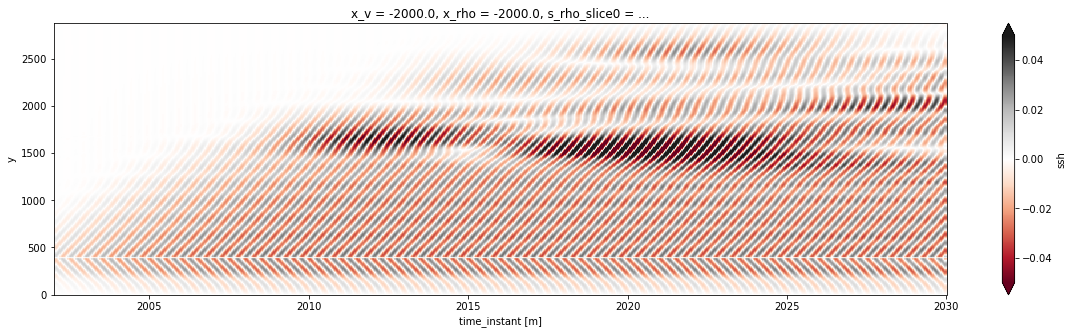

In [40]:
pkw = {'vmin': -.05, 'vmax': .05, 'cmap': 'RdGy', 'xlim': (2002,2030), 'figsize': (20,5)}
((V_omega[0]).isel(time=slice(2*24*6,30*24*6,6))
    .plot(x='time', y='y', **pkw)
)

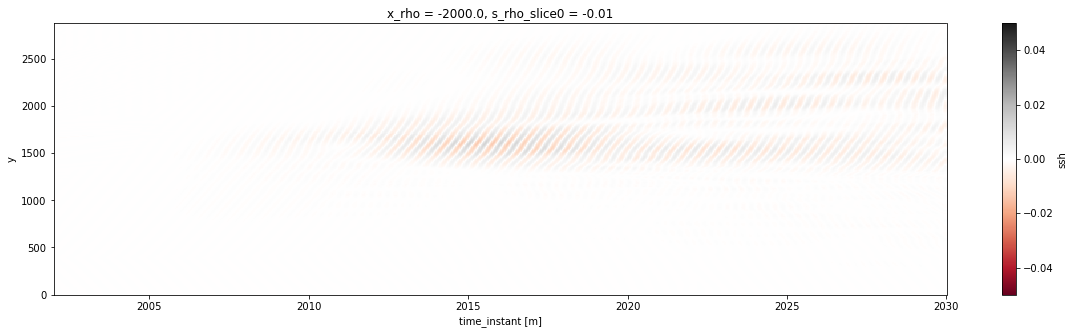

In [41]:
i=1
((V_omega[i].shift(time=-int(start_shifts[i]*24*6))-V_omega[0])
  .isel(time=slice(2*24*6,30*24*6,6))
  .plot(x='time', y='y', **pkw)
)

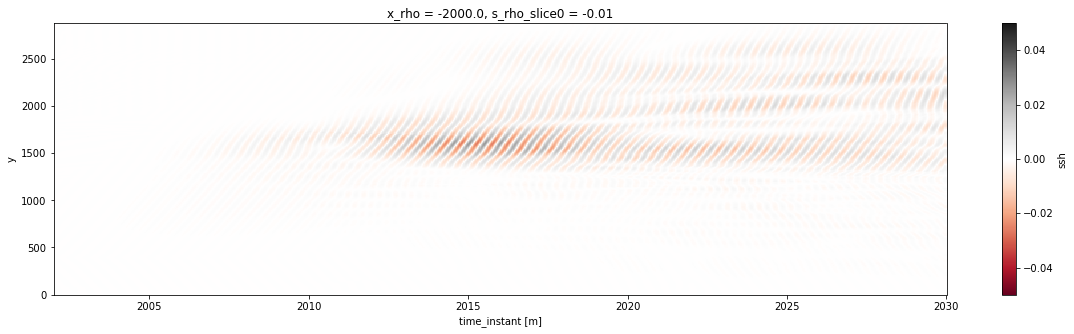

In [42]:
i=2
((V_omega[i].shift(time=-int(start_shifts[i]*24*6))-V_omega[0])
  .isel(time=slice(2*24*6,30*24*6,6))
  .plot(x='time', y='y', **pkw)
)

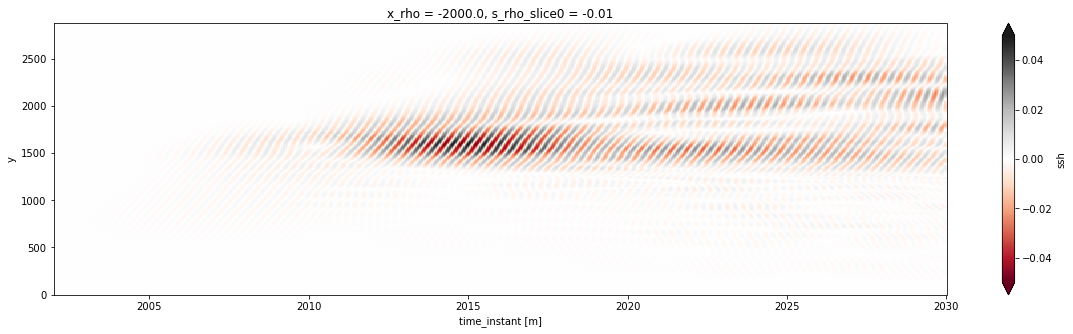

In [43]:
i=3
((V_omega[i].shift(time=-int(start_shifts[i]*24*6))-V_omega[0])
  .isel(time=slice(2*24*6,30*24*6,6))
  .plot(x='time', y='y', **pkw)
)

In [44]:
dV_omega = [(v.shift(time=-int(s*24*6))-V_omega[0])
            .isel(time=slice(2*24*6,30*24*6,6))
            for s, v in zip(start_shifts[1:], V_omega[1:])]

In [45]:
dV_omega = xr.concat(dV_omega, dim='shift').assign_coords(shift=start_shifts[1:])

In [ ]:
ax = plt.subplots(1, figsize=(5,8))
nlin.plot(y='y', color='orange')
# add internal tide amplitude
lin.isel(amplitude=0).plot(y='y', color='k')
ax[1].set_title('')
ax[1].grid()

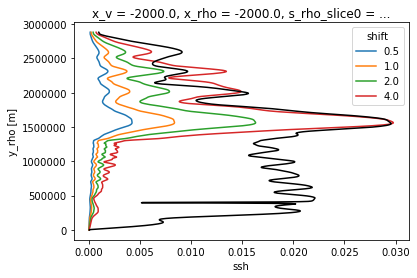

In [59]:
dV_omega.std('time').plot.line(y='y_rho')
(V_omega[0].isel(time=slice(2*24*6,30*24*6,6))
 .std('time')
 .plot(y='y_rho', color='k')
)

---

## load data

In [24]:
#root_path = '/home/c11-data/Test_aponte/jetn/'
#root_path = '/home1/scratch/aponte/'
root_path = '/home/datawork-lops-osi/equinox/jetn/'

nmode = 1

runs = ([root_path+'jet_wp5_ptb_m1_p4'] + 
        [root_path+'jet_wp5_dstart_m%d_%d'%(nmode, i) for i in range(4)]
       )
R = []
for r in runs:
    _r = pp.Run(r, open_nc=['ave'])
    _r['ave'] = _r['ave'].rename({'time_counter': 'time'})
    R.append(_r)
R

#run = 'jet_cfg1_wp75_4km_0a1500j'
#r = pp.Run(root_path+run, prefix='file_', open_nc=['ave'], verbose=True)

#run = 'jet_cfg1_wp75_4km_1500a2000j_itide'
#r = pp.Run(root_path+run, open_nc=['ave'], verbose=True)

[Run: /home/datawork-lops-osi/equinox/jetn/jet_wp5_ptb_m1_p4
   datasets suffixes: grid / ave,
 Run: /home/datawork-lops-osi/equinox/jetn/jet_wp5_dstart_m1_0
   datasets suffixes: grid / ave,
 Run: /home/datawork-lops-osi/equinox/jetn/jet_wp5_dstart_m1_1
   datasets suffixes: grid / ave,
 Run: /home/datawork-lops-osi/equinox/jetn/jet_wp5_dstart_m1_2
   datasets suffixes: grid / ave,
 Run: /home/datawork-lops-osi/equinox/jetn/jet_wp5_dstart_m1_3
   datasets suffixes: grid / ave]

In [25]:
R[0].params_output

{'itide_omega': 0.000145,
 'itide_nmode': 2.0,
 'itide_Az': 0.02,
 'itide_y': 400000.0,
 'itide_start_time': 2000.0,
 'itideptb_flag': 3.0,
 'itideptb_dcos': 1.0,
 'itideptb_dsin': 0.0,
 'itideptb_nmode': 2.0,
 'itideptb_scale': 1.0,
 'jet_ywidth': 800000.0,
 'jet_weight': 0.5,
 'jet_decay_start': 2000.0,
 'tdiag_omega': 0.000145,
 'relax_dist_south': 1000000.0,
 'relax_L_south': 350000.0,
 'relax_tau_in_south': 1000.0,
 'relax_tau_out_south': 1.0,
 'relax_dist_north': 1000000.0,
 'relax_L_north': 350000.0,
 'relax_tau_in_north': 1000.0,
 'relax_tau_out_north': 1.0,
 'depth': 4000.0,
 'f0': 0.000103,
 'beta': 1.62e-11,
 'yrbeta': 1440000.0,
 'itideptb_truth_Acos_mode': array([0.00e+00, 1.46e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]),
 'itideptb_truth_Asin_mode': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'itideptb_normalized': 1.0,
 'itideptb_full_Acos_mode': array([0.00e+00, 1.46e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
   

In [20]:
# slice at x center and concatenate into a single dataset with dimensions amplitude
ds = (xr.concat([r['ave']['ssh_t_cos'].isel(x_rho=0) for r in R], 
               dim='delay')
      .chunk({'time':None})
     )

#amplitudes = [r['itideptb_full_Acos_mode'][nmode] for r in R]
#ds = ds.assign_coords(amplitude=xr.DataArray(amplitudes, dims='amplitude'))

ds = ds.persist()
ds

<xarray.DataArray 'ssh_t_cos' (delay: 4, time: 50, y_rho: 722)>
dask.array<rechunk-merge, shape=(4, 50, 722), dtype=float32, chunksize=(1, 50, 722), chunktype=numpy.ndarray>
Coordinates:
    f_u            (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    x_rhoy         float32 510000.0
    time_centered  (time) datetime64[ns] dask.array<chunksize=(50,), meta=np.ndarray>
    x_vy           float32 510000.0
    y_u            (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    s_rho_slice0   float32 -0.01
    x_rho          float32 -2000.0
    x_uy           float32 508000.0
    f_rho          (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    x_v            float32 -2000.0
  * time           (time) float64 2.001e+03 2.003e+03 ... 2.097e+03 2.099e+03
  * y_rho          (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
Dimensions without coordinates: delay
Attributes:
    long_name:           ssh x cos
    units:               m
    online_operation:    average
    interval_operation:  300 s
    interval_write:      2 d
    cell_methods:        time: mean (interval: 300 s)

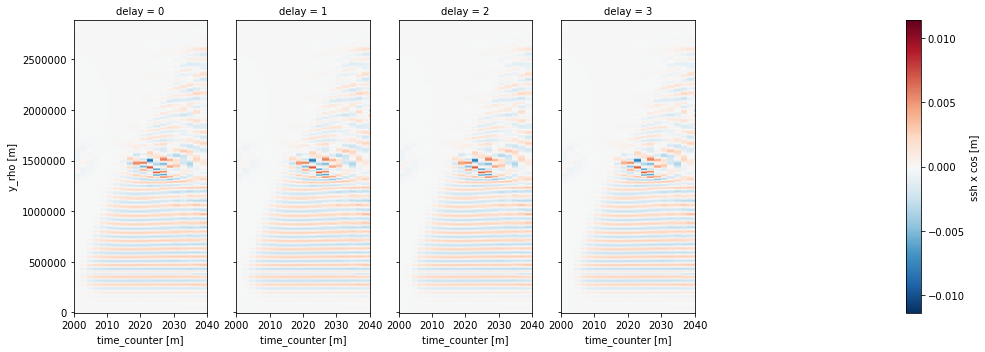

In [21]:
ds.plot(x='time', y='y_rho', 
        col='delay', col_wrap=5,
        figsize=(15,5), xlim=(2000,2040))

---

In [ ]:
cluster.close()